In [1]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
# Step 2: Separate features and labels
X = df.drop("Class", axis=1)
y = df["Class"]

In [4]:
# Step 3: Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [5]:
# Step 4: Apply SMOTE only to training data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [6]:
# Step 5: Initialize models
lightgbm = LGBMClassifier(random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

In [7]:
# Step 6: Train models
lightgbm.fit(X_train_sm, y_train_sm)
mlp.fit(X_train_sm, y_train_sm)

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

In [8]:
# Step 7: Make predictions
# LightGBM
y_train_pred_lgb = lightgbm.predict(X_train_sm)
y_test_pred_lgb = lightgbm.predict(X_test)


In [9]:
# MLP
y_train_pred_mlp = mlp.predict(X_train_sm)
y_test_pred_mlp = mlp.predict(X_test)


In [10]:
# Step 8: Evaluation function
def evaluate(y_true_train, y_pred_train, y_true_test, y_pred_test):
    return {
        "train_acc": accuracy_score(y_true_train, y_pred_train),
        "test_acc": accuracy_score(y_true_test, y_pred_test),
        "train_recall": recall_score(y_true_train, y_pred_train),
        "test_recall": recall_score(y_true_test, y_pred_test),
        "train_f1": f1_score(y_true_train, y_pred_train),
        "test_f1": f1_score(y_true_test, y_pred_test),
    }


In [11]:
# Step 9: Get scores
results_lgb = evaluate(y_train_sm, y_train_pred_lgb, y_test, y_test_pred_lgb)
results_mlp = evaluate(y_train_sm, y_train_pred_mlp, y_test, y_test_pred_mlp)


In [12]:
# Step 10: Plot the results
labels = ["Train Accuracy", "Val Accuracy", "Train Recall", "Val Recall", "Train F1", "Val F1"]
lgb_scores = list(results_lgb.values())
mlp_scores = list(results_mlp.values())

x = range(len(labels))
bar_width = 0.35

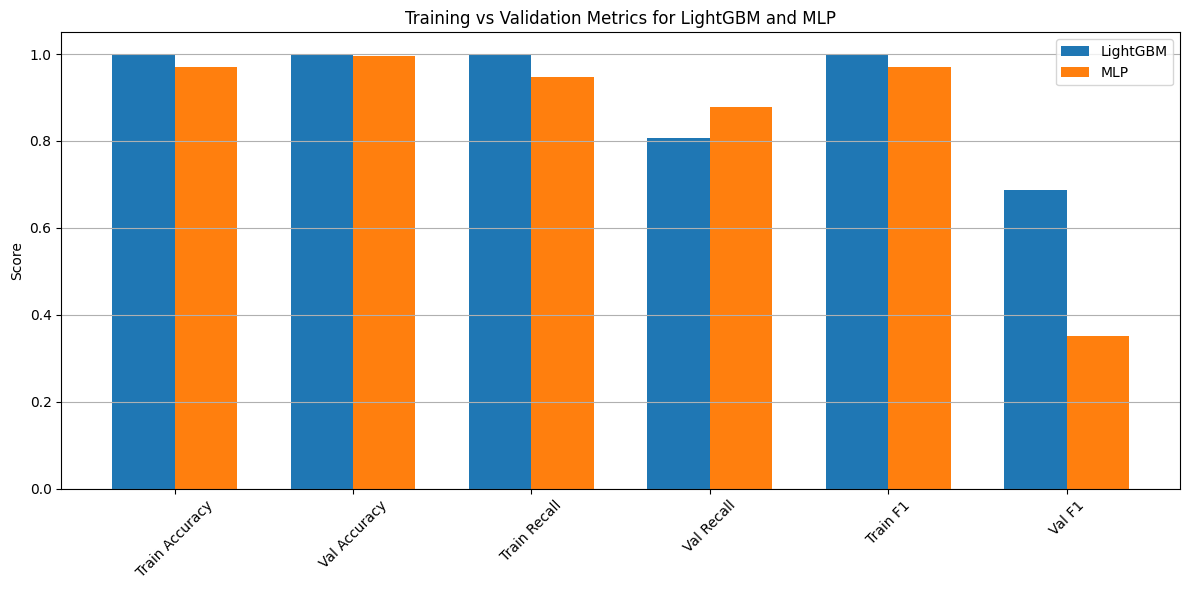

In [13]:
plt.figure(figsize=(12, 6))
plt.bar(x, lgb_scores, width=bar_width, label='LightGBM')
plt.bar([i + bar_width for i in x], mlp_scores, width=bar_width, label='MLP')

# Set x-axis labels between the grouped bars
plt.xticks([i + bar_width/2 for i in x], labels, rotation=45)

plt.ylabel('Score')
plt.title('Training vs Validation Metrics for LightGBM and MLP')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
